1. **Clean dataset** → remove corrupted images.
2. **Normalize images** → pixel values 0–1.
3. **Create train/validation datasets** → shuffle and batch.
4. **Build CNN model** → Conv2D, MaxPooling, Flatten, Dense, Dropout.
5. **Compile model** → optimizer, loss, metrics.
6. **Train model** → use `model.fit(train_ds, validation_data=val_ds, epochs=...)`.
7. **Check results** → plot accuracy/loss or evaluate on validation set.
8. **Save model** → `model.save(...)`.
9. **Deploy / predict** → load model and run predictions.


**Download The dataset**

In [14]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
Path to dataset files: /kaggle/input/new-plant-diseases-dataset


**Create DataFrame From the image data**

In [24]:
import pandas as pd
import os
import warnings
from sklearn.utils import shuffle
warnings.filterwarnings('ignore')

# Actual training folder
train_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

input_path = []
label = []

# Loop through class folders
for class_name in os.listdir(train_path):
    class_folder = os.path.join(train_path, class_name)
    if os.path.isdir(class_folder):
        for f in os.listdir(class_folder):
            full_path = os.path.join(class_folder, f)
            # Make sure it is a file and an image
            if os.path.isfile(full_path) and f.lower().endswith(('.jpg', '.jpeg', '.png')):
                input_path.append(f)
                label.append(class_name)

# Create DataFrame
df = pd.DataFrame({
    "file": input_path,
    "label_name": label
})

# Shuffle and take only 20k images
df = shuffle(df, random_state=42).reset_index(drop=True)
df = df.iloc[:20000]

# Combine folder + file
df['file'] = df['label_name'].astype(str) + '/' + df['file'].astype(str)

# Summary
print(df.head())
print("\nTotal images:", len(df))
print("\nUnique labels:", df['label_name'].nunique())
print("\nImage count per class (top 10):\n", df['label_name'].value_counts().head(10))


                                                file  \
0  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
1  Strawberry___Leaf_scorch/25b3d990-6ed3-450d-9e...   
2  Squash___Powdery_mildew/8b35bf64-3045-46f6-afc...   
3  Apple___healthy/3817a269-0274-4a5c-b851-46e91b...   
4  Raspberry___healthy/7abacf3e-e438-471a-aacf-84...   

                                          label_name  
0  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...  
1                           Strawberry___Leaf_scorch  
2                            Squash___Powdery_mildew  
3                                    Apple___healthy  
4                                Raspberry___healthy  

Total images: 20000

Unique labels: 38

Image count per class (top 10):
 label_name
Apple___Black_rot                           589
Soybean___healthy                           574
Tomato___Leaf_Mold                          573
Pepper,_bell___healthy                      572
Apple___healthy                             565
Tomato__

**Explotary Data Analysis**

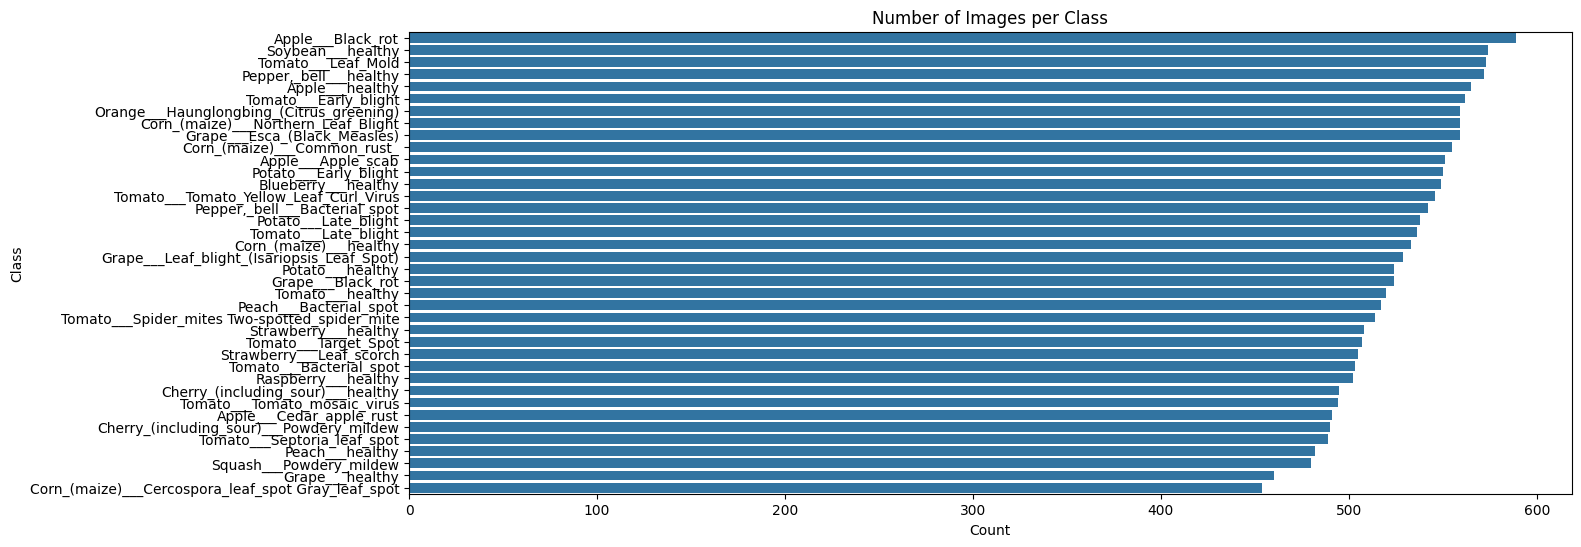

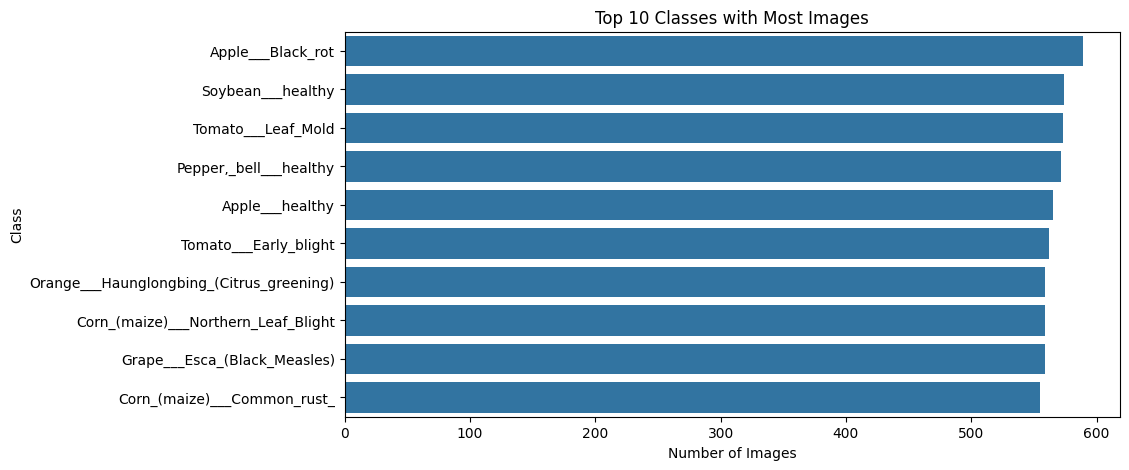

Total Images: 20000
Total Classes: 38

Image count per class (summary stats):
count     38.000000
mean     526.315789
std       33.761569
min      454.000000
25%      502.250000
50%      526.500000
75%      554.000000
max      589.000000
Name: count, dtype: float64


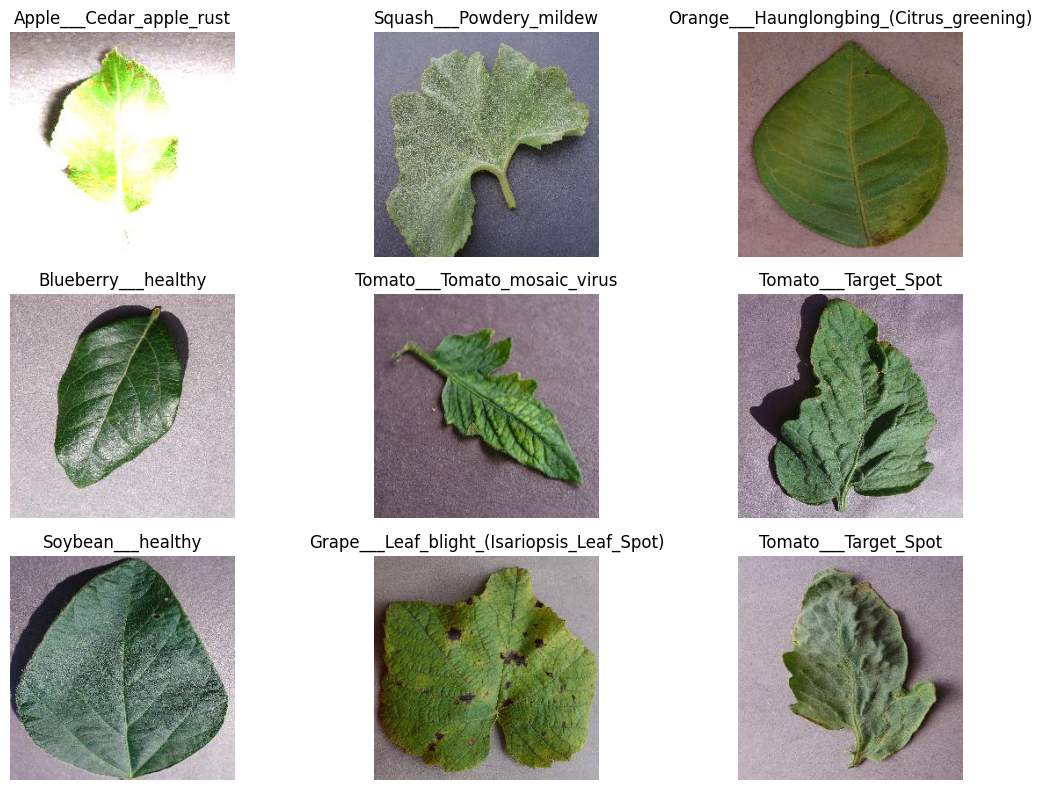

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Number of images per class
# -------------------------------
plt.figure(figsize=(15,6))
sns.countplot(y='label_name', data=df, order=df['label_name'].value_counts().index)
plt.title("Number of Images per Class")
plt.xlabel("Count")
plt.ylabel("Class")
plt.show()

# -------------------------------
# 2. Top 10 classes with most images
# -------------------------------
top10 = df['label_name'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top10.values, y=top10.index)
plt.title("Top 10 Classes with Most Images")
plt.xlabel("Number of Images")
plt.ylabel("Class")
plt.show()

# -------------------------------
# 3. Distribution stats
# -------------------------------
print("Total Images:", len(df))
print("Total Classes:", df['label_name'].nunique())
print("\nImage count per class (summary stats):")
print(df['label_name'].value_counts().describe())

# -------------------------------
# 4. Show some sample images
# -------------------------------
import matplotlib.image as mpimg
import random

plt.figure(figsize=(12,8))
for i in range(9):
    sample = df.sample(1).iloc[0]
    img_path = os.path.join(train_path, sample['file'])
    img = mpimg.imread(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(sample['label_name'])
    plt.axis('off')
plt.tight_layout()
plt.show()


**Create DataGenerator for the images**

A **DataGenerator** is a Python object that **loads and preprocesses images in batches** during model training instead of loading all at once.
It helps **save memory** and can **apply real-time data augmentation** like rotation, flipping, or scaling.
Basically, it **feeds the model images batch by batch efficiently**.


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------------------
# 1. Define Data Augmentation
# -------------------------------
# We create an ImageDataGenerator object to:
# - Normalize pixel values (rescale)
# - Apply random transformations to increase dataset variability
# - Split data into training and validation subsets

train_datagen = ImageDataGenerator(
    rescale=1./255,             # normalize pixel values from 0-255 to 0-1 for faster training
    rotation_range=20,           # randomly rotate images up to 20 degrees to make model rotation-invariant
    width_shift_range=0.1,       # shift image horizontally by 10% to improve robustness to object position
    height_shift_range=0.1,      # shift image vertically by 10% to improve robustness
    shear_range=0.1,             # apply shear transformation (slanting) for augmentation
    zoom_range=0.1,              # randomly zoom in/out to help model generalize
    horizontal_flip=True,        # randomly flip images horizontally (plants can appear flipped)
    vertical_flip=False,         # vertical flip usually not needed for plants
    validation_split=0.2         # reserve 20% of data for validation
)

# -------------------------------
# 2. Create Training Generator
# -------------------------------
# flow_from_dataframe loads images **batch by batch** from disk instead of loading all at once.
# This saves memory and allows real-time data augmentation.

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,                # the dataframe containing filenames and labels
    directory=train_path,        # base folder containing class subfolders
    x_col="file",                # column in df with image file names (folder/filename)
    y_col="label_name",          # column in df with labels (class names)
    target_size=(128,128),       # resize images to 224x224 (common for CNNs like ResNet)
    batch_size=16,               # number of images per batch
    class_mode="categorical",    # multi-class classification: labels are one-hot encoded
    subset="training",           # only use the training portion (80% of data)
    shuffle=True                 # shuffle images each epoch for better training
)

# -------------------------------
# 3. Create Validation Generator
# -------------------------------
# Validation generator uses the same dataframe but subset="validation" (20% data).
# No shuffling is needed for validation.
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col="file",
    y_col="label_name",
    target_size=(128,128),
    batch_size=16,
    class_mode="categorical",
    subset="validation",         # validation subset
    shuffle=False                # keep order fixed for evaluation
)


Found 16000 validated image filenames belonging to 38 classes.
Found 4000 validated image filenames belonging to 38 classes.


**Model Creation**

In [37]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

num_classes = df['label_name'].nunique()

# Load pretrained backbone
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # freeze for initial training

# Build top layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Checkpoint
checkpoint = ModelCheckpoint("best_plant_disease_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# Train top layers first
history = model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[checkpoint])

# -------------------------------
# Fine-tuning: unfreeze last layers
base_model.trainable = True
for layer in base_model.layers[:-20]:  # freeze earlier layers
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[checkpoint])


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.4678 - loss: 1.9512
Epoch 1: val_accuracy improved from -inf to 0.84625, saving model to best_plant_disease_model.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 312s 306ms/step - accuracy: 0.4680 - loss: 1.9506 - val_accuracy: 0.8462 - val_loss: 0.5115
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7620 - loss: 0.7585
Epoch 2: val_accuracy improved from 0.84625 to 0.86075, saving model to best_plant_disease_model.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 294s 294ms/step - accuracy: 0.7620 - loss: 0.7585 - val_accuracy: 0.8608 - val_loss: 0.4197
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7974 - loss: 0.6367
Epoch 3: val_accuracy improved from 0.86075 to 0.87150, saving model to best_plant_disease_model.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 295s 295ms/step - accuracy: 0.7974 - loss: 0.6367 - val_accuracy: 0.8715 - val_loss: 0.3880
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8122 - loss: 0.5850
Epoch 4: val_accuracy improved from 0.87150 to 0.88025, saving model to best_plant_disease_model.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 298s 298ms/step - accuracy: 0.8122 - loss: 0.5850 - val_accuracy: 0.8802 - val_loss: 0.3456
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8164 - loss: 0.5729
Epoch 5: val_accuracy improved from 0.88025 to 0.89125, saving model to best_plant_disease_model.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 319s 319ms/step - accuracy: 0.8165 - loss: 0.5729 - val_accuracy: 0.8913 - val_loss: 0.3380
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.8301 - loss: 0.5235
Epoch 6: val_accuracy did not improve from 0.89125
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 299s 299ms/step - accuracy: 0.8301 - loss: 0.5235 - val_accuracy: 0.8905 - val_loss: 0.3240
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8376 - loss: 0.4932
Epoch 7: val_accuracy did not improve from 0.89125
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 298s 298ms/step - accuracy: 0.8376 - loss: 0.4932 - val_accuracy: 0.8880 - val_loss: 0.3340
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8425 - loss: 0.4915
Epoch 8: val_accuracy did not improve from 0.89125
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 297s 297ms/step - accuracy: 0.8425 - loss: 0.4915 - val_accuracy: 0.8888 - val_loss: 0.3257
Epoch 9/10
 378/1000 ━━━━━━━━━━━━━━━━━━━━ 2:28 239ms/step - accuracy: 0.8463 - loss: 

KeyboardInterrupt: 

**Train the model**

**EarlyStopping** automatically stops training the model when it no longer improves on validation data, saving time and preventing overfitting. With `restore_best_weights=True`, it keeps the model weights from the epoch that performed best, so you don’t need to retrain.

**ModelCheckpoint** saves the best version of the model automatically, so after training stops, you already have the best model ready for evaluation or prediction. You only retrain if you want to try more epochs or change the model settings.

**It it too slow ..We will use Pretrained Mobile Net**

**Pretrained MobileNet** is a ready-made convolutional neural network that has already been trained on a large dataset called ImageNet (over 1 million images of 1000 classes). It has learned general visual features like edges, shapes, textures, and patterns that are useful for almost any image classification task.

By using **MobileNet** as pretrained, you don’t need to train all the layers from scratch — you only train a new classification head for your specific dataset (here, 38 plant disease classes). This makes training much faster and usually gives better accuracy, even with smaller datasets.

**If we want to continue training just load the model**

In [ ]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # -------------------------------
# # 1. Load previously saved best model
# # -------------------------------
# model = load_model("best_plant_disease_model.h5")  # load your saved MobileNet model


# checkpoint = ModelCheckpoint(
#     "best_plant_disease_TL_model.h5",  # overwrite best weights if improved
#     monitor='val_accuracy',
#     save_best_only=True,
#     verbose=1
# )

# # -------------------------------
# # 3. Continue training
# # -------------------------------
# history = model.fit(
#     train_generator,
#     validation_data=valid_generator,
#     epochs=50,          # continue for more epochs
#     callbacks=[early_stop, checkpoint]
# )


NameError: name 'history_fine' is not defined

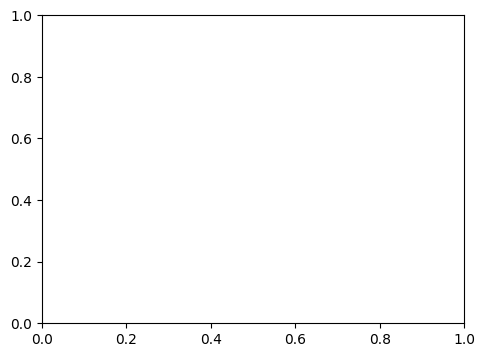

In [41]:

# -------------------------------
# 3. Plot Training History
# -------------------------------
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_fine.history_fine['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history_fine['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_fine.history_fine['loss'], label='Train Loss')
plt.plot(history_fine.history_fine['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [46]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# -------------------------------
# 1. Load your saved model
# -------------------------------
model = load_model("best_plant_disease_model.h5")

# -------------------------------
# 2. Upload image from user
# -------------------------------
uploaded = files.upload()  # this will prompt user to upload an image

for img_name in uploaded.keys():
    img_path = img_name

    # -------------------------------
    # 3. Preprocess the image
    # -------------------------------
    img = image.load_img(img_path, target_size=(128,128))  # same size as training
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)           # make it batch of 1
    img_array = preprocess_input(img_array)                 # preprocess like MobileNetV2

    # -------------------------------
    # 4. Predict
    # -------------------------------
    preds = model.predict(img_array)
    class_index = np.argmax(preds[0])                      # get the index of max probability
    confidence = preds[0][class_index]

    # -------------------------------
    # 5. Map index to class label
    # -------------------------------
    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[class_index]

    print(f"Predicted class: {predicted_label}")
    print(f"Confidence: {confidence:.2f}")


Saving 0eb2593a-5e67-4f13-91ea-105831323d54___Mt.N.V_HL 6117_new30degFlipLR.JPG to 0eb2593a-5e67-4f13-91ea-105831323d54___Mt.N.V_HL 6117_new30degFlipLR.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Grape___healthy
Confidence: 0.96


In [42]:
from google.colab import files
files.download("best_plant_disease_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>